**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**August, 2023**


---

# All samples preprocessing

scRNA-Seq of Placental explants

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc
import gc
    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/images/preprocessing/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [2]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= '', fig_format='svg'):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    ax1.set_xlim(0, 100)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.'+fig_format, bbox_inches='tight',
                       dpi=300, orientation='landscape', format= fig_format, optimize=True)

### Import data

In [7]:
adata = sc.read('../data/snRNA1_counts_Pf_adata.h5ad')

In [8]:
set(adata.obs["batch"])

{'0', '1', '2', '3', '4', '5', '6', '7'}

### Subsetting only the hs genes taken from the Lm object

In [8]:
#Keeping hs genes only
#adata_Tg= adata_Tg[:, list(adata_Lm.var.index)].copy()

In [14]:

 ## all human genes]
hsGenes= list(adata.var.gene_ids[adata.var.gene_ids.str.startswith('ENSG')].index)


In [9]:
#The intersection will only be hs genes
hsGenes= list(set(adata_Lm.var.index).intersection(set(adata_Pf.var.index)))

In [18]:
#Pf data has less genes due to Reginas preprocessing. Keeping only those ones
adata= adata[:, hsGenes].copy()

# QC plots

In [19]:
## Deleting the cells expressing less than 10 genes
sc.pp.filter_cells(adata, min_genes=10)
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 105409


In [20]:
sc.set_figure_params(figsize=(20,10))

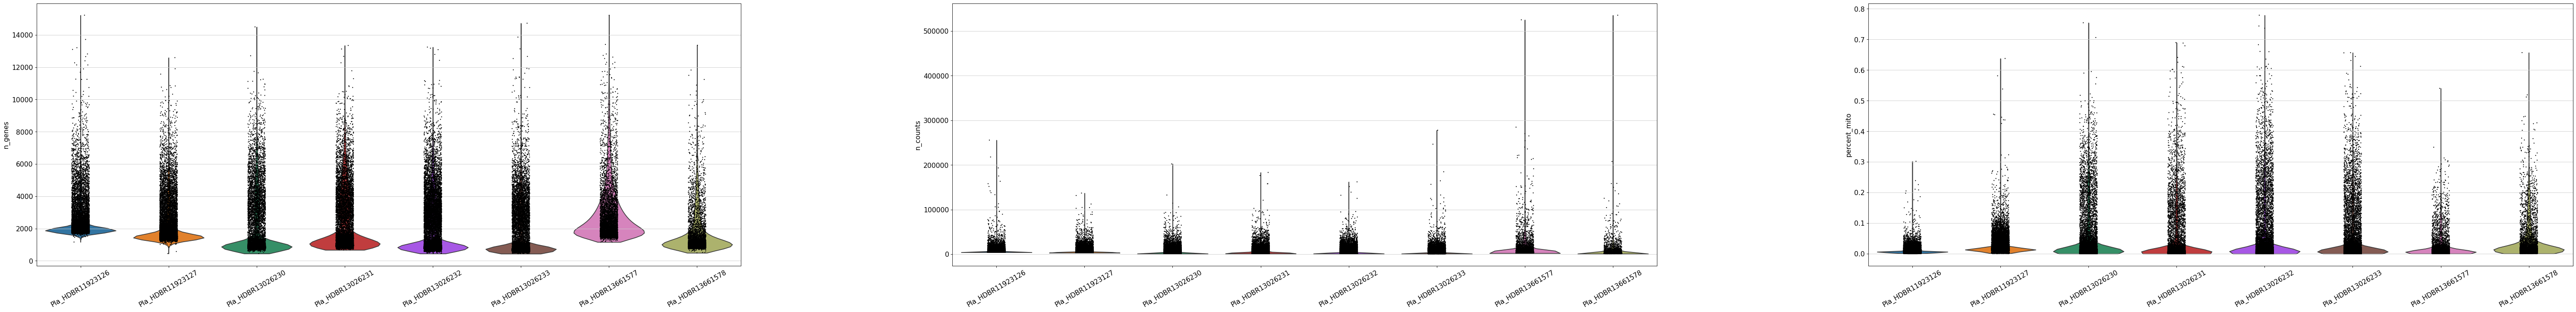

In [21]:
#sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_before_qc.pdf') 
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=30, save='_beforeQC_all.pdf', wspace=3, size=2) 

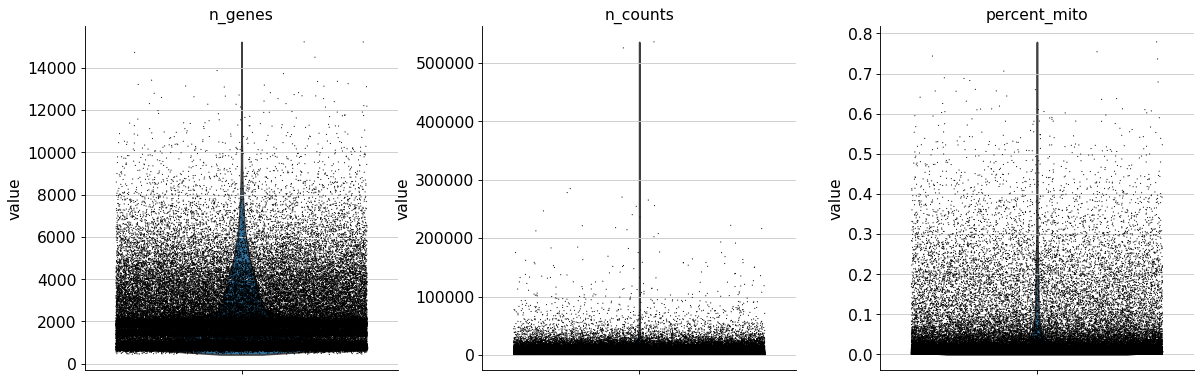

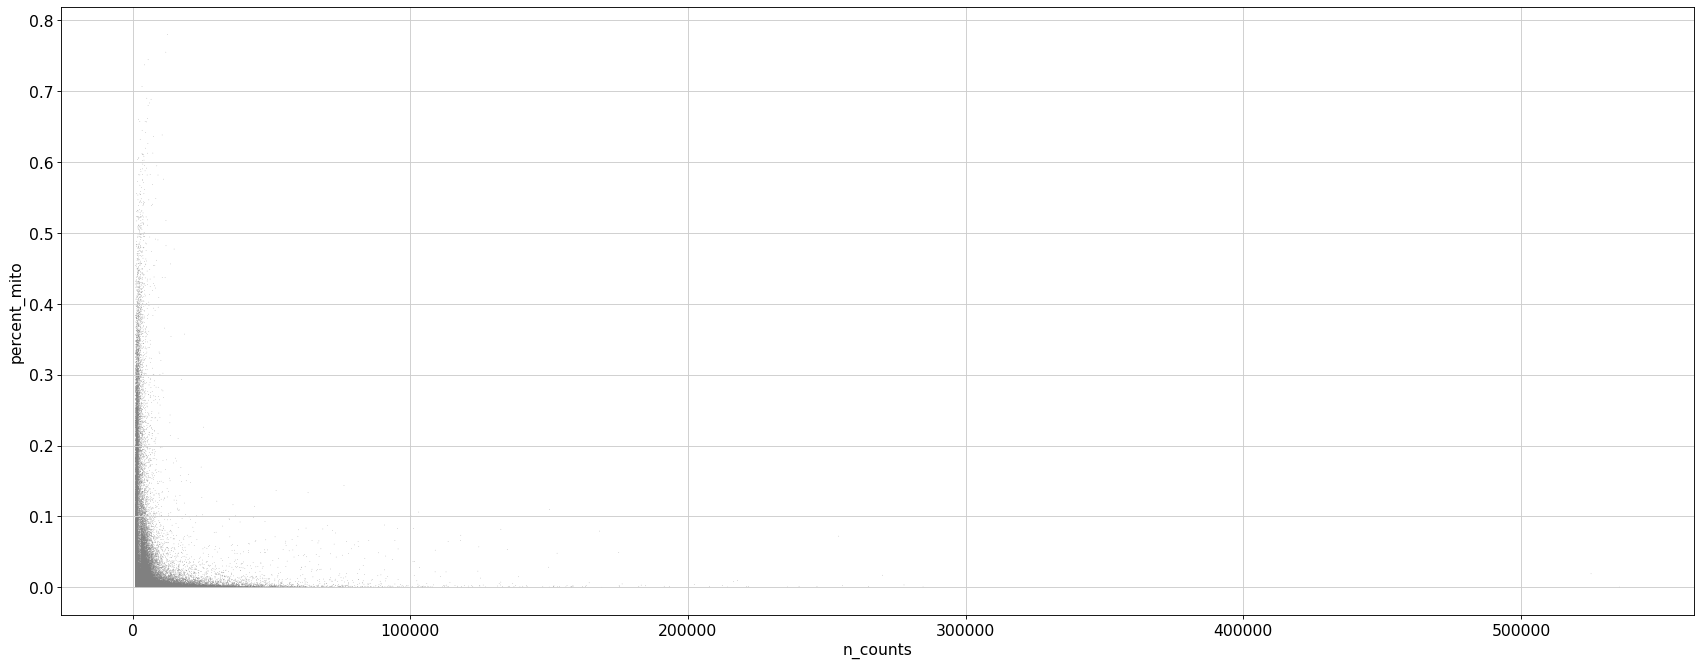

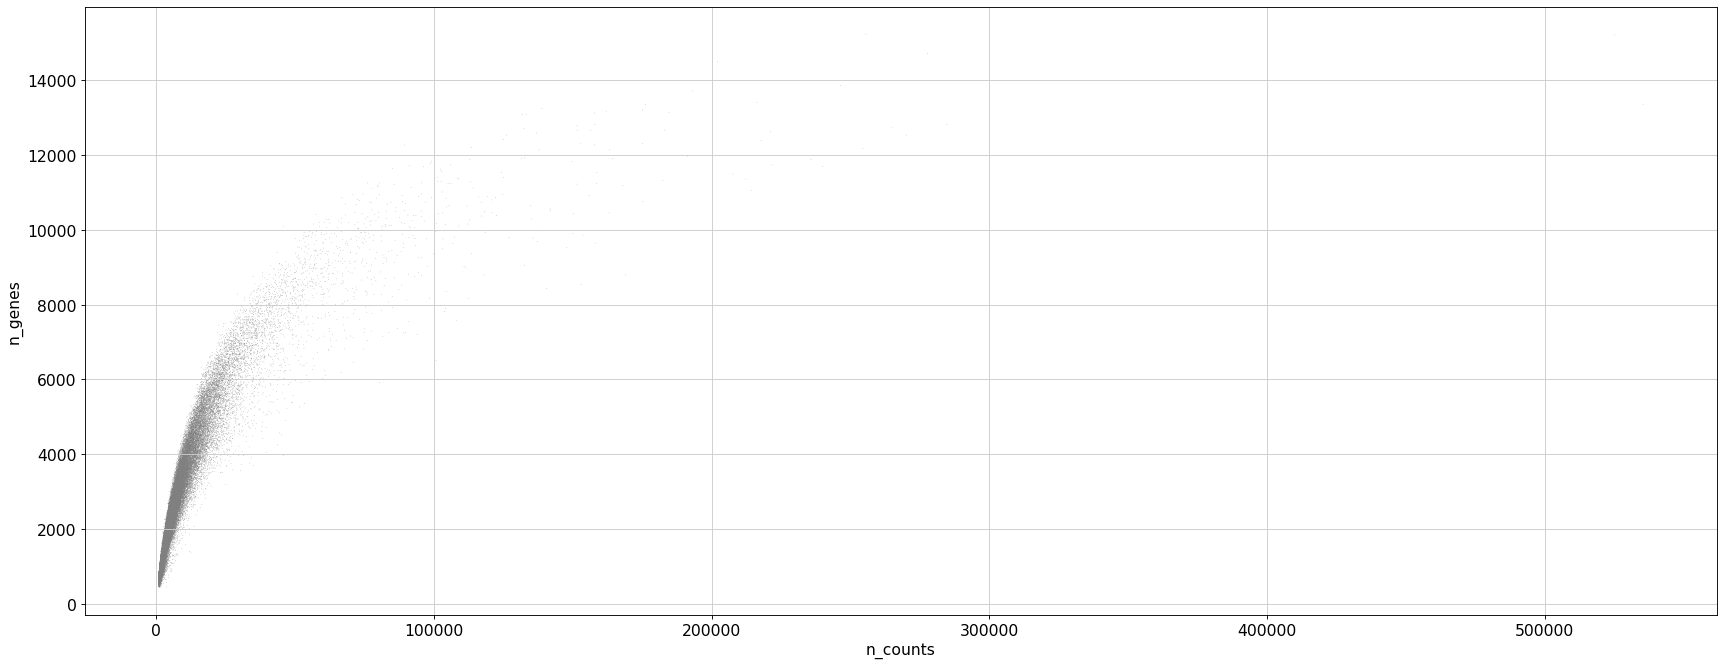

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='_All.pdf')
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numiVSmito_All.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numiVSngenes_All.pdf')

In [23]:
adata

AnnData object with n_obs × n_vars = 105409 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'assignment_SoC', 'donor_deconv', 'donor_souporcell', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'sample_colors'
    layers: 'raw_counts'

### Filtering the number of genes

In [24]:
sc.set_figure_params(figsize=(6.4,4.8))

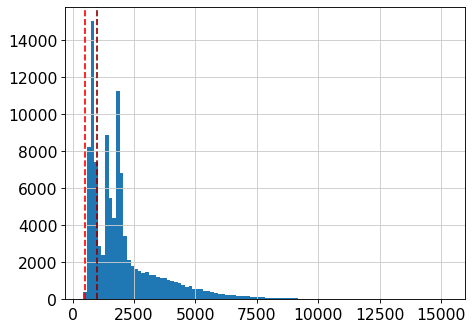

In [25]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(500, linestyle = '--', color = 'red')
plt.axvline(1000, linestyle = '--', color = 'darkred')

In [26]:
#deleting the cells expressing less than 1000 genes
sc.pp.filter_cells(adata, min_genes=1000)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


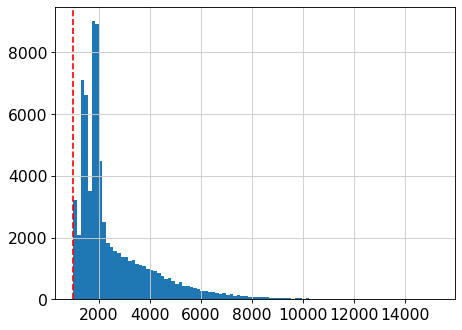

In [27]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(1000, linestyle = '--', color = 'red')

In [28]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
#adata.obs['donor_souporcell'].values.describe()
adata.obs['sample'].values.describe()

Total number of cells: 75215
Total number of genes: 36601


,counts,freqs
categories,,
Pla_HDBR11923126,22821,0.303410
Pla_HDBR11923127,19012,0.252769
Pla_HDBR13026230,4776,0.063498
Pla_HDBR13026231,7735,0.102839
Pla_HDBR13026232,7597,0.101004
Pla_HDBR13026233,4978,0.066184
Pla_HDBR13661577,5536,0.073602
Pla_HDBR13661578,2760,0.036695



### Filter cells by counts

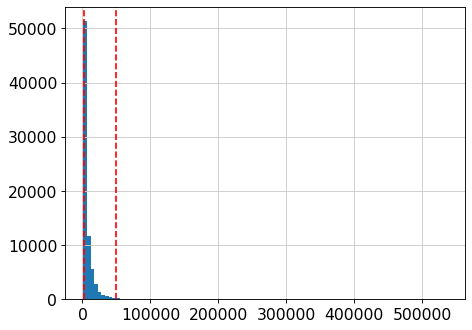

In [29]:
plt.hist(adata.obs['n_counts'], bins = 100)
plt.axvline(2000, linestyle = '--', color = 'red')
plt.axvline(50000, linestyle = '--', color = 'red')

In [30]:
sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 71545


In [31]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 71545
Total number of genes: 36601



### Filter cells with large % mitochondrial genes

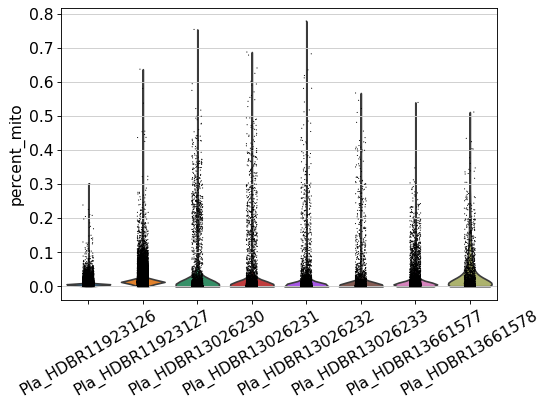

In [32]:
#sc.pl.violin(adata, ['percent_mito'], groupby='donor_souporcell', rotation=45 ) #hPGCs
sc.pl.violin(adata, ['percent_mito'], groupby='sample', rotation=30 ) #hPGCs

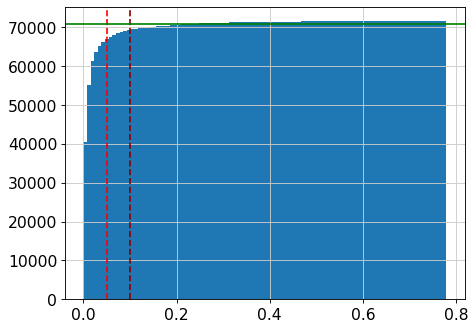

In [33]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.05, linestyle = '--', color = 'red')
plt.axvline(0.1, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [34]:
# Keeping cells with <5%
adata = adata[adata.obs['percent_mito'] < 0.05, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [35]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 66486
Total number of genes: 36601


In [36]:
adata

View of AnnData object with n_obs × n_vars = 66486 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'assignment_SoC', 'donor_deconv', 'donor_souporcell', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'sample_colors'
    layers: 'raw_counts'

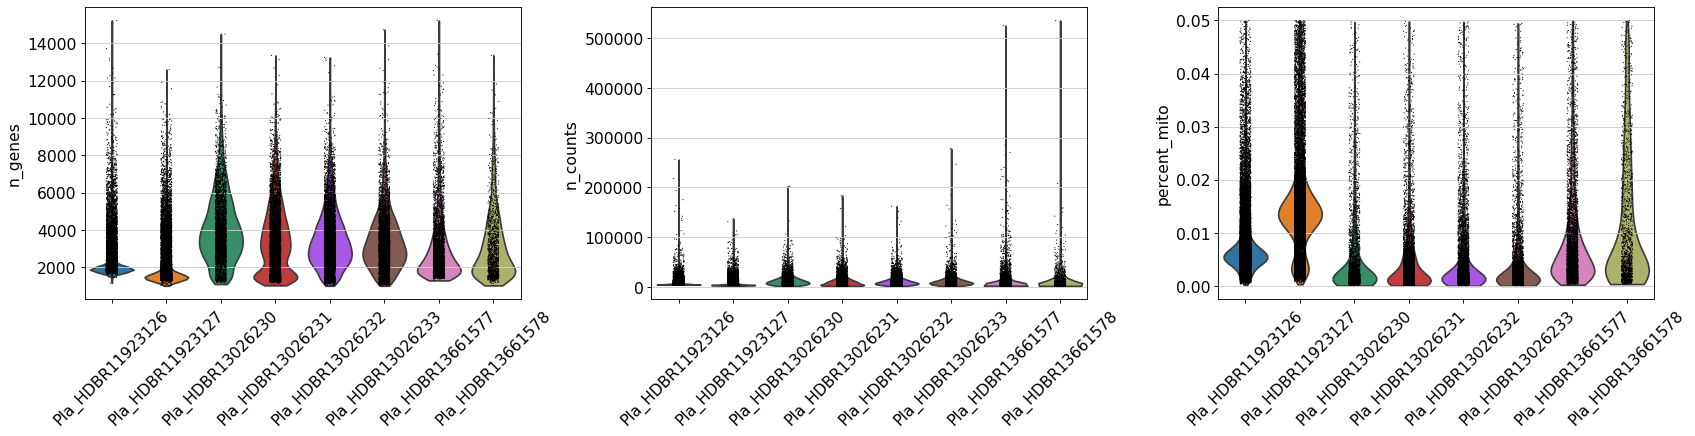

Trying to set attribute `.uns` of view, copying.


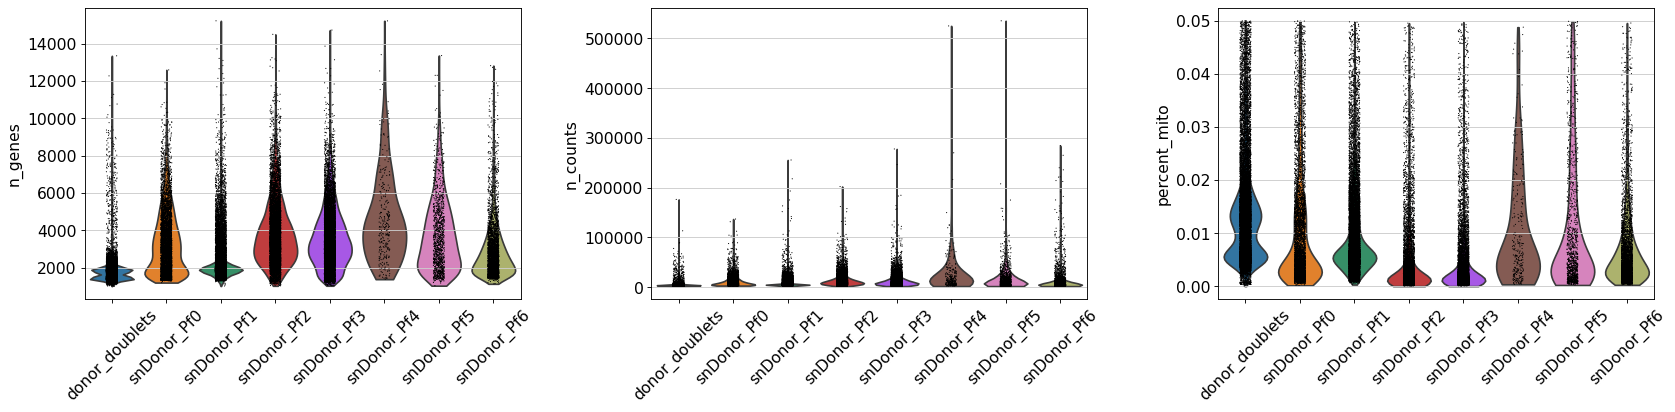

In [37]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=45, save='_afterQC_Sample.pdf')
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_id', rotation=45, save='_afterQC_Donor.pdf') 

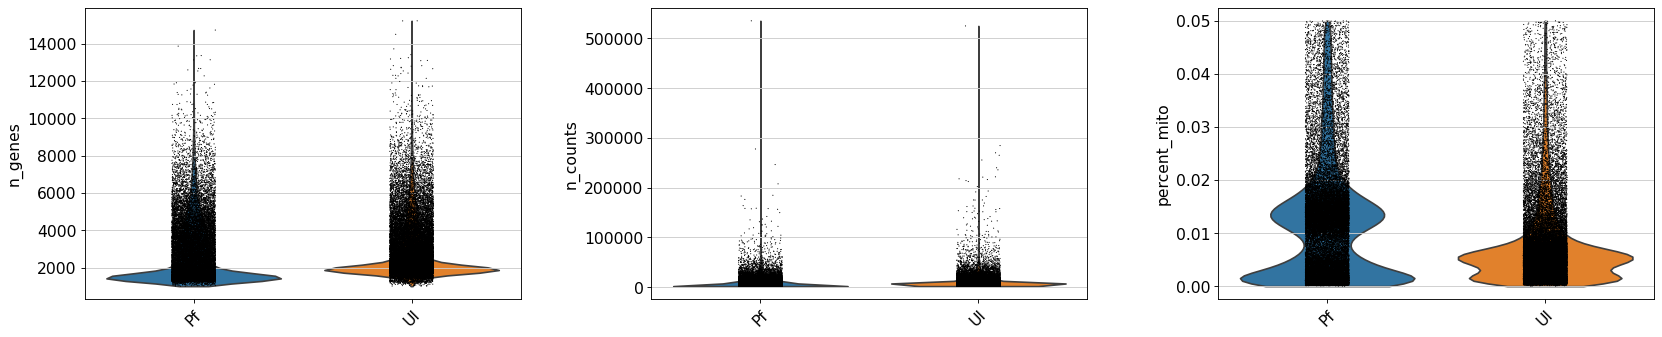

In [38]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='infection', rotation=45, save='_afterQC_Infection.pdf')

In [39]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR11923126,22634,0.340433
Pla_HDBR11923127,17021,0.256009
Pla_HDBR13026230,3555,0.053470
Pla_HDBR13026231,5709,0.085868
Pla_HDBR13026232,6772,0.101856
Pla_HDBR13026233,4508,0.067804
Pla_HDBR13661577,4924,0.074061
Pla_HDBR13661578,1363,0.020501


In [40]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_id'].values.describe()
#adata.obs['donor_souporcell'].values.describe()

Total number of cells: 66486
Total number of genes: 36601


,counts,freqs
categories,,
donor_doublets,21841,0.328505
snDonor_Pf0,5567,0.083732
snDonor_Pf1,14911,0.224273
snDonor_Pf2,8476,0.127485
snDonor_Pf3,10308,0.155040
snDonor_Pf4,277,0.004166
snDonor_Pf5,1177,0.017703
snDonor_Pf6,3929,0.059095


In [41]:
adata= adata[adata.obs['donor_id'] != 'snDonor_Pf4']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_id'].values.describe()
#adata.obs['donor_souporcell'].values.describe()

Total number of cells: 66209
Total number of genes: 36601


,counts,freqs
categories,,
donor_doublets,21841,0.329880
snDonor_Pf0,5567,0.084082
snDonor_Pf1,14911,0.225211
snDonor_Pf2,8476,0.128019
snDonor_Pf3,10308,0.155689
snDonor_Pf5,1177,0.017777
snDonor_Pf6,3929,0.059342


## Highly variable genes


In [39]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.


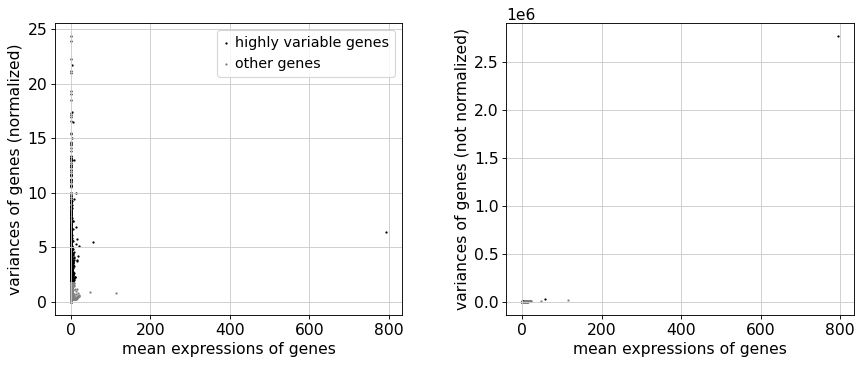

Total number of cells: 66209
Total number of genes: 36601


In [43]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)


print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

In [44]:
adata

AnnData object with n_obs × n_vars = 66209 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'assignment_SoC', 'donor_deconv', 'donor_souporcell', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'sample_colors', 'donor_id_colors', 'infection_colors', 'hvg'
    layers: 'raw_counts'


### Saving raw counts

In [45]:
adata.write('../data/snRNA1_counts_preprocessed_All_adata.h5ad')
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')